In [ ]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import ast
import re
import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('mel_features_dataset.csv')

In [ ]:
X = df['Mel_Features'].values
y = df['Ragas'].values

In [ ]:
print("Shape of X before reshape:", X.shape)
print("Shape of y before encode:", y.shape)

Shape of X before reshape: (174,)
Shape of y before encode: (174,)


In [ ]:
le=LabelEncoder()
ti=le.fit_transform(y)
y_mel=to_categorical(ti)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y_mel,test_size=0.2,random_state=127)

In [ ]:
num_classes = len(y_mel[0])
print(num_classes)

9


In [ ]:
#X_train_flat = np.array([x.flatten() for x in X_train])
y_train_numerical = np.argmax(y_train, axis=1)
y_test_numerical = np.argmax(y_test, axis=1)
y_train_encoded = to_categorical(y_train_numerical, num_classes=num_classes)
y_test_encoded = to_categorical(y_test_numerical, num_classes=num_classes)

In [ ]:
print(X_train[0])

[[-49.23179  -40.900173 -35.22286  ... -80.       -80.       -80.      ]
 [-49.131256 -37.39643  -26.980406 ... -80.       -80.       -80.      ]
 [-50.548172 -39.183334 -25.958849 ... -80.       -80.       -80.      ]
 ...
 [-50.58346  -31.450312 -25.43192  ... -80.       -80.       -80.      ]
 [-50.48502  -32.110584 -25.729435 ... -80.       -80.       -80.      ]
 [-43.868637 -31.801788 -25.15377  ... -80.       -80.       -80.      ]]


In [ ]:
print(type(X_train))
print(X_train.shape)
print(type(X_train[0]))

<class 'numpy.ndarray'>
(139,)
<class 'str'>


In [ ]:
def remove_nan_from_list_np(data_list):
    temp_array = np.array(data_list)
    return temp_array[~np.isnan(temp_array)].tolist()

In [ ]:
def cleaned_string_array(arr, cleaned_list):
  for i, str_array in enumerate(arr):
    try:
      cleaned_str_array = str_array.strip('[]')
      cleaned_str_array = ' '.join(cleaned_str_array.split())
      sio = io.StringIO(cleaned_str_array)
      numerical_array = np.genfromtxt(sio, dtype=float)
      cleaned_list.append(numerical_array)
    except Exception as e:
        print(f"Error processing sample{e}")

In [ ]:
loaded_X_train = []
loaded_X_test = []

cleaned_string_array(X_train, loaded_X_train)
cleaned_string_array(X_test, loaded_X_test)

In [ ]:
s_Train = pd.Series(loaded_X_train)
s_Test = pd.Series(loaded_X_test)
cleaned_X_train = s_Train.apply(remove_nan_from_list_np)
cleaned_X_test = s_Test.apply(remove_nan_from_list_np)

In [ ]:
print(type(cleaned_X_train))
print(cleaned_X_train.shape)
print(cleaned_X_train.head())

<class 'pandas.core.series.Series'>
(139,)
0    [-49.23179, -40.900173, -35.22286, -80.0, -80....
1    [-73.1736, -65.56986, -46.832676, -80.0, -80.0...
2    [-33.193417, -38.61211, -47.274662, -65.94535,...
3    [-26.856775, -29.381496, -30.761852, -69.10777...
4    [-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -80...
dtype: object


In [ ]:
#Padding the spectrograms
padded_X_train_list = []
for spec_list in cleaned_X_train:
    if len(spec_list) < 31:
        padded_spec = spec_list + [-80.0] * (31 - len(spec_list))
    else:
        padded_spec = spec_list[:31]
    padded_X_train_list.append(padded_spec)

In [ ]:
cleaned_X_train_np = np.array(padded_X_train_list, dtype=np.float32)

In [ ]:
print(f"Shape of NumPy array after padding: {cleaned_X_train_np.shape}")

Shape of NumPy array after padding: (139, 31)


In [ ]:
cleaned_X_train_reshaped = cleaned_X_train_np.reshape(
    cleaned_X_train_np.shape[0], 31, 1
)
print(f"Final reshaped array shape for 1D CNN: {cleaned_X_train_reshaped.shape}")

Final reshaped array shape for 1D CNN: (139, 31, 1)


In [ ]:
model_mel = Sequential()
model_mel.add(Conv1D(32, 3, activation='relu', input_shape=(31, 1)))
model_mel.add(MaxPooling1D(pool_size=2))
model_mel.add(Conv1D(64, 3, activation='relu'))
model_mel.add(Flatten())
model_mel.add(Dense(128, activation='relu'))
model_mel.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model_mel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_mel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 29, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,929 (413.79 KB)

 Trainable params: 105,929 (413.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(y_train_encoded.shape)
print(y_test_encoded.shape)

(139, 9)
(35, 9)


In [ ]:
#Padding the test data spectrograms
padded_X_test_list = []
for spec_list in cleaned_X_test:
    if len(spec_list) < 31:
        padded_spec = spec_list + [-80.0] * (31 - len(spec_list))
    else:
        padded_spec = spec_list[:31]
    padded_X_test_list.append(padded_spec)

In [ ]:
cleaned_X_test_np = np.array(padded_X_test_list, dtype=np.float32)
print(f"Shape of NumPy array after padding: {cleaned_X_test_np.shape}")

Shape of NumPy array after padding: (35, 31)


In [ ]:
cleaned_X_test_reshaped = cleaned_X_test_np.reshape(
    cleaned_X_test_np.shape[0], 31, 1
)
print(f"Final reshaped array shape for 1D CNN: {cleaned_X_test_reshaped.shape}")

Final reshaped array shape for 1D CNN: (35, 31, 1)


In [ ]:
history_mel = model_mel.fit(cleaned_X_train_reshaped, y_train_encoded, epochs=30, batch_size=32, validation_data=(cleaned_X_test_reshaped, y_test_encoded))

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.1455 - loss: 7.3622 - val_accuracy: 0.0857 - val_loss: 7.6351
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1113 - loss: 4.9298 - val_accuracy: 0.0857 - val_loss: 6.3048
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2871 - loss: 3.4969 - val_accuracy: 0.1714 - val_loss: 5.4005
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2210 - loss: 3.1320 - val_accuracy: 0.2000 - val_loss: 4.5100
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2832 - loss: 2.5175 - val_accuracy: 0.1714 - val_loss: 3.7505
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3593 - loss: 2.2383 - val_accuracy: 0.2000 - val_loss: 3.3242
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3751 - loss: 2.2400 - val_accuracy: 0.1429 - val_loss: 2.9559
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2791 - loss: 1.8892 - val_accuracy: 0.1429 - val_loss: 2.6832


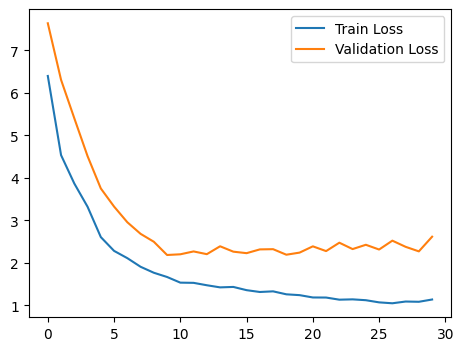

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mel.history['loss'], label='Train Loss')
plt.plot(history_mel.history['val_loss'], label='Validation Loss')
plt.legend()

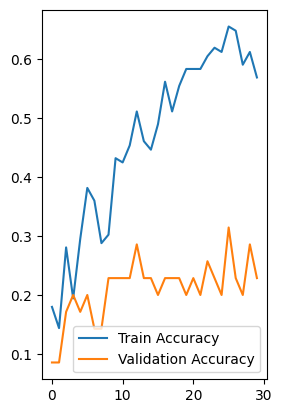

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history_mel.history['accuracy'], label='Train Accuracy')
plt.plot(history_mel.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
test_df = pd.read_csv('test_mel_dataset.csv')

In [ ]:
X_test_mel = test_df['Mel_Features'].values
y_test_mel = test_df['Ragas'].values

In [ ]:
print (model_mel.input_shape[1])

31


In [ ]:
y_test_encoded = le.fit_transform(y_test_mel)
num_classes_test = len(np.unique(y_test_encoded))
y_test_categorical_test = to_categorical(y_test_encoded, num_classes=num_classes_test)
print(num_classes_test)

9


In [ ]:
print(X_test_mel.shape)

(94,)


In [ ]:
loaded_X_test_mel = []
cleaned_string_array(X_test_mel, loaded_X_test_mel)

In [ ]:
s_Test_mel = pd.Series(loaded_X_test_mel)
cleaned_X_test_mel = s_Test_mel.apply(remove_nan_from_list_np)

In [ ]:
padded_X_test_mel = []
for spec_list in cleaned_X_test_mel:
    if len(spec_list) < 31:
        padded_spec = spec_list + [-80.0] * (31 - len(spec_list))
    else:
        padded_spec = spec_list[:31]
    padded_X_test_mel.append(padded_spec)

In [ ]:
cleaned_X_test_np_mel = np.array(padded_X_test_mel, dtype=np.float32)
print(f"Shape of NumPy test array after padding: {cleaned_X_test_np_mel.shape}")

Shape of NumPy test array after padding: (94, 31)


In [ ]:
cleaned_X_test_reshaped_mel = cleaned_X_test_np_mel.reshape(
    cleaned_X_test_np_mel.shape[0], 31, 1
)
print(f"Final reshaped array shape: {cleaned_X_test_reshaped_mel.shape}")

Final reshaped array shape: (94, 31, 1)


In [ ]:
predictions = model_mel.predict(cleaned_X_test_reshaped_mel)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [ ]:
predicted_classes = np.argmax(predictions, axis=1)
original_predicted_classes = le.inverse_transform(predicted_classes)


Classification Report:
              precision    recall  f1-score   support

     Asavari       1.00      0.20      0.33        10
   Bageshree       0.50      0.67      0.57        12
    Bhairava       0.20      0.42      0.27        12
    Bhairavi       0.40      0.20      0.27        10
    Bhoopali       0.00      0.00      0.00        10
     Darbari       0.60      0.30      0.40        10
    Malkauns       0.75      0.60      0.67        10
      Sarang       0.67      0.20      0.31        10
       Yaman       0.27      0.80      0.40        10

    accuracy                           0.38        94
   macro avg       0.49      0.38      0.36        94
weighted avg       0.48      0.38      0.36        94



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


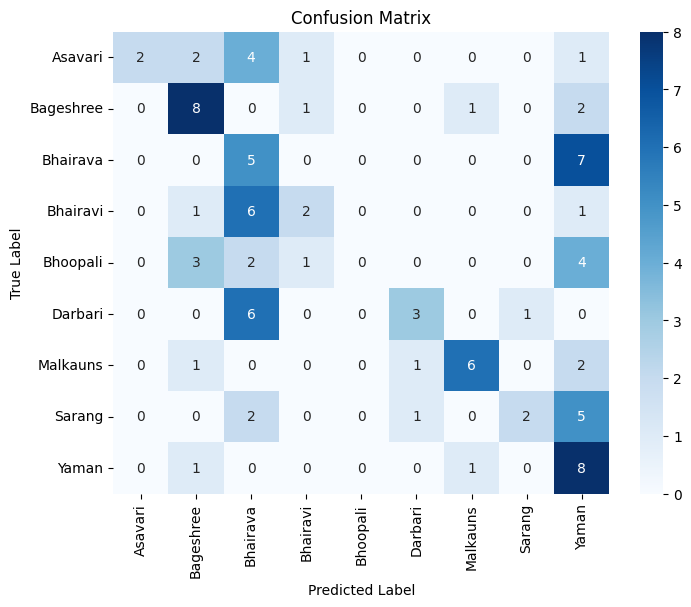

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\nClassification Report:")
print(classification_report(y_test_mel, original_predicted_classes))
cm = confusion_matrix(y_test_mel, original_predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
